In [3]:
import math, json, os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [27]:
"""
Train PyTorch embeddings + MLP on the Census mini‑sample (50 rows).

Assumes sample.csv is in the same directory.

"""


# ───────────────────────────────────────────────────────────────────────────────
# 1. Load data & identify columns
# ───────────────────────────────────────────────────────────────────────────────
df = pd.read_csv("sample.csv")

target_col = "income bracket"
y_raw = df[target_col].str.strip().map({"- 50000.": 0, "50000+.": 1}).values
X = df.drop(columns=[target_col])

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print(f"{len(cat_cols)} categorical columns  |  {len(num_cols)} numerical columns")



28 categorical columns  |  13 numerical columns


In [5]:
# ───────────────────────────────────────────────────────────────────────────────
# 2. Encode categorical & scale numerical
# ───────────────────────────────────────────────────────────────────────────────
cat_encoders, cat_data = {}, []
for col in cat_cols:
    le = LabelEncoder()
    cat_arr = le.fit_transform(X[col].fillna("NA").astype(str))
    cat_encoders[col] = le
    cat_data.append(torch.tensor(cat_arr, dtype=torch.long))
cat_data = torch.stack(cat_data, dim=1)           # [N, C]

if num_cols:
    scaler = StandardScaler().fit(X[num_cols])
    num_data = torch.tensor(scaler.transform(X[num_cols]),
                            dtype=torch.float32)   # [N, M]
else:
    num_data = torch.empty((len(df), 0))

y = torch.tensor(y_raw, dtype=torch.float32)

train_idx, test_idx = train_test_split(
    np.arange(len(df)), test_size=0.3, random_state=42, stratify=y_raw)


In [31]:
# ───────────────────────────────────────────────────────────────────────────────
# 3. Build model
# ───────────────────────────────────────────────────────────────────────────────
def emb_dim_rule(card):
    """Heuristic: min(50, round(1.6 * card^0.56))"""
    return int(min(50, round(1.6 * card ** 0.56)))

# class CensusNet(nn.Module):
#     def __init__(self, embedding_sizes, n_cont, out_sz, layers, p=0.5, col_names=None):
#         super().__init__()
#         self.emb_layers = nn.ModuleList([
#             nn.Embedding(cat_sz, emb_sz)
#             for cat_sz, emb_sz in embedding_sizes
#         ])
#         self.col_names = col_names  # list of column names in same order as embedding_sizes

#         # ... (rest of your model setup)

#     @property
#     def embeddings(self):
#         # Return dict: col_name → corresponding nn.Embedding
#         return {
#             col: emb
#             for col, emb in zip(self.col_names, self.emb_layers)
#         }


# class CensusNet(nn.Module):
#     def __init__(self, embedding_sizes, n_cont, out_sz, layers, p=0.5, col_names=None):
#         super().__init__()
#         self.emb_layers = nn.ModuleList([
#             nn.Embedding(cat_sz, emb_sz)
#             for cat_sz, emb_sz in embedding_sizes
#         ])
#         emb_total_dim = sum(e.embedding_dim for e in self.embeds)
#         self.mlp = nn.Sequential(
#             nn.Linear(emb_total_dim + num_inputs, 32),
#             nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid()
#         )
        
#     @property
#     def embeddings(self):
#         # Return dict: col_name → corresponding nn.Embedding
#         return {
#             col: emb
#             for col, emb in zip(self.col_names, self.emb_layers)
#         }
    
#     def forward(self, cat_x, num_x):
#         embs = [emb(cat_x[:, i]) for i, emb in enumerate(self.embeds)]
#         x = torch.cat(embs + [num_x], dim=1)
#         return self.mlp(x).squeeze()



class CensusNet(nn.Module):
    def __init__(self, embedding_sizes, n_cont, out_sz, layers, p=0.5, col_names=None):
        """
        embedding_sizes: List of (num_categories, emb_dim) tuples
        n_cont: Number of continuous (numeric) columns
        out_sz: Output size (e.g., 1 or 2)
        layers: List of MLP hidden layer sizes
        p: Dropout probability
        col_names: List of categorical column names (same order as embedding_sizes)
        """
        super().__init__()

        self.emb_layers = nn.ModuleList([
            nn.Embedding(cat_sz, emb_sz)
            for cat_sz, emb_sz in embedding_sizes
        ])

        self.col_names = col_names  # Needed for .embeddings property

        n_emb = sum(e[1] for e in embedding_sizes)  # total embedding dim
        layerlist = []
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU())
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i

        layerlist.append(nn.Linear(n_in, out_sz))
        self.mlp = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embs = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
        x = torch.cat(embs + [x_cont], dim=1)
        return self.mlp(x).squeeze()

    @property
    def embeddings(self):
        """Access embeddings by column name"""
        if self.col_names is None:
            raise ValueError("col_names must be set in model to access named embeddings.")
        return {col: emb for col, emb in zip(self.col_names, self.emb_layers)}

        

# # Step 1: Ensure you have cat_cols and cat_encoders
# cat_cols = [...]  # e.g., ['education', 'occupation', ...]
cat_encoders = {
    col: LabelEncoder().fit(df[col].astype(str).fillna("NA"))
    for col in cat_cols
}

# Step 2: Define embedding sizes
embedding_sizes = [
    (len(le.classes_), min(50, (len(le.classes_) + 1) // 2))
    for le in cat_encoders.values()
]

model = CensusNet(
    embedding_sizes=embedding_sizes,
    n_cont=len(cat_cols),
    out_sz=2,
    layers=[100, 50],
    p=0.5,
    col_names=cat_cols,  # <- pass the list of categorical column names
)


In [32]:
# # Step 1: Ensure you have cat_cols and cat_encoders
# cat_cols = [...]  # e.g., ['education', 'occupation', ...]
cat_encoders = {
    col: LabelEncoder().fit(df[col].astype(str).fillna("NA"))
    for col in cat_cols
}

# Step 2: Define embedding sizes
embedding_sizes = [
    (len(le.classes_), min(50, (len(le.classes_) + 1) // 2))
    for le in cat_encoders.values()
]


In [33]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. Train
# ───────────────────────────────────────────────────────────────────────────────
crit = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    opt.zero_grad()
    out = model(cat_data[train_idx], num_data[train_idx])
    loss = crit(out, y[train_idx])
    loss.backward()
    opt.step()
    print('Epoch:',epoch)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (35000x217 and 232x100)

In [9]:
# ───────────────────────────────────────────────────────────────────────────────
# 5. Evaluate
# ───────────────────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    preds = (model(cat_data[test_idx], num_data[test_idx]) > 0.5).int()
acc = accuracy_score(y[test_idx].int(), preds)
print(f"\nHold‑out accuracy: {acc:.2f}\n")
print(classification_report(y[test_idx].int(), preds))



Hold‑out accuracy: 0.94

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14073
           1       0.54      0.44      0.48       927

    accuracy                           0.94     15000
   macro avg       0.75      0.71      0.73     15000
weighted avg       0.94      0.94      0.94     15000



In [10]:


# ───────────────────────────────────────────────────────────────────────────────
# 6. Inspect embeddings
# ───────────────────────────────────────────────────────────────────────────────
print("Learned embeddings:")
for col, emb_layer in zip(cat_cols, model.embeds):
    weights = emb_layer.weight.data.cpu().numpy()
    print(f"\n{col} (dim={emb_layer.embedding_dim})")
    for cat_idx, cat in enumerate(cat_encoders[col].classes_[:4]):  # first 4
        print(f"  {cat:<30} → {np.round(weights[cat_idx], 3)}")
    if len(cat_encoders[col].classes_) > 4:
        print("  ...")


Learned embeddings:

class of worker (dim=5)
   Federal government            → [-1.006  0.05  -0.408 -0.793 -0.497]
   Local government              → [ 0.958 -0.529  0.357  1.02   0.584]
   Never worked                  → [-1.851 -0.226  2.817 -1.578 -1.304]
   Not in universe               → [ 1.675 -0.124 -0.061  0.121 -0.093]
  ...

education (dim=8)
   10th grade                    → [ 2.26   0.055  0.39  -0.379 -2.014 -1.54   0.587 -0.108]
   11th grade                    → [ 0.533  0.217 -0.267 -1.069  0.374 -1.964 -1.702 -0.191]
   12th grade no diploma         → [ 0.506 -1.469 -0.933 -1.66  -0.443  1.122 -1.853  1.309]
   1st 2nd 3rd or 4th grade      → [ 0.092 -2.285  1.378 -0.5    0.497  1.368 -0.485  0.518]
  ...

enroll in edu inst last wk (dim=3)
   College or university         → [ 1.911  1.676 -0.604]
   High school                   → [-3.007 -0.305  0.688]
   Not in universe               → [-0.768 -0.295 -1.201]

marital stat (dim=5)
   Divorced                     

In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Function to visualize embeddings from a categorical column
def visualize_embedding(model, col_name, encoder, method='tsne', figsize=(8,6)):
    """
    Visualize embeddings for a categorical column from a trained model.

    Args:
        model: Trained PyTorch model with `embeddings` dict
        col_name: Column name (e.g., 'education')
        encoder: dict mapping category string → integer index (used in training)
        method: 'pca' or 'tsne'
    """
    emb_layer = model.embeddings[col_name]
    weights = emb_layer.weight.detach().cpu().numpy()

    labels = list(encoder.keys())

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=5, random_state=42)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    reduced = reducer.fit_transform(weights)

    plt.figure(figsize=figsize)
    plt.scatter(reduced[:, 0], reduced[:, 1], c='skyblue', edgecolors='k')

    for i, label in enumerate(labels):
        plt.text(reduced[i, 0], reduced[i, 1], label, fontsize=9)

    plt.title(f"Embedding visualization for: {col_name} ({method.upper()})")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
cat_encoders

{'class of worker': LabelEncoder(),
 'education': LabelEncoder(),
 'enroll in edu inst last wk': LabelEncoder(),
 'marital stat': LabelEncoder(),
 'major industry code': LabelEncoder(),
 'major occupation code': LabelEncoder(),
 'race': LabelEncoder(),
 'hispanic origin': LabelEncoder(),
 'sex': LabelEncoder(),
 'member of a labor union': LabelEncoder(),
 'reason for unemployment': LabelEncoder(),
 'full or part time employment stat': LabelEncoder(),
 'tax filer stat': LabelEncoder(),
 'region of previous residence': LabelEncoder(),
 'state of previous residence': LabelEncoder(),
 'detailed household and family stat': LabelEncoder(),
 'detailed household summary in household': LabelEncoder(),
 'migration code-change in msa': LabelEncoder(),
 'migration code-change in reg': LabelEncoder(),
 'migration code-move within reg': LabelEncoder(),
 'live in this house 1 year ago': LabelEncoder(),
 'migration prev res in sunbelt': LabelEncoder(),
 'family members under 18': LabelEncoder(),
 'cou

In [15]:
encoders = {
    col: {cls: idx for idx, cls in enumerate(le.classes_)}
    for col, le in cat_encoders.items()
}


In [ ]:
visualize_embedding(model, col_name, encoder, method='tSNE', figsize=(8,6))


In [17]:
# Suppose you want to see how 'education' categories cluster
visualize_embedding(
    model,                 # ← your trained CensusNet instance
    col_name='education',  # ← any categorical column you like
    encoder=encoders['education'],
    method='tsne'          # or 'pca'
)


AttributeError: 'CensusNet' object has no attribute 'embeddings'

In [19]:
model.embeddings

AttributeError: 'CensusNet' object has no attribute 'embeddings'

In [18]:
encoders['education']

{' 10th grade': 0,
 ' 11th grade': 1,
 ' 12th grade no diploma': 2,
 ' 1st 2nd 3rd or 4th grade': 3,
 ' 5th or 6th grade': 4,
 ' 7th and 8th grade': 5,
 ' 9th grade': 6,
 ' Associates degree-academic program': 7,
 ' Associates degree-occup /vocational': 8,
 ' Bachelors degree(BA AB BS)': 9,
 ' Children': 10,
 ' Doctorate degree(PhD EdD)': 11,
 ' High school graduate': 12,
 ' Less than 1st grade': 13,
 ' Masters degree(MA MS MEng MEd MSW MBA)': 14,
 ' Prof school degree (MD DDS DVM LLB JD)': 15,
 ' Some college but no degree': 16}

In [20]:
def visualize_embedding(model, col_name, encoder, method='tsne', figsize=(8,6)):
    """
    encoder can be:
        • dict {category → idx}
        • or sklearn LabelEncoder (has .classes_)
    """
    # Handle both types
    if hasattr(encoder, "classes_"):               # LabelEncoder
        label_to_idx = {cls: i for i, cls in enumerate(encoder.classes_)}
    else:                                          # pre‑built dict
        label_to_idx = encoder

    emb_layer = model.embeddings[col_name]
    weights   = emb_layer.weight.detach().cpu().numpy()
    labels    = list(label_to_idx.keys())
    ...


In [21]:
visualize_embedding(model, 'education', cat_encoders['education'], method='pca')


AttributeError: 'CensusNet' object has no attribute 'embeddings'

In [34]:
# train_tabular_embeddings_fixed.py
"""
End‑to‑end example:
    • Load Census sample.csv (50 rows)
    • Preprocess: split categorical vs numeric, label‑encode cats, scale nums
    • Build CensusNet with named .embeddings property
    • Train simple MLP on concatenated embeddings + numeric features
    • Provide helpers for:
        – visualize_embedding(col_name, method)
        – get_row_embedding(row)
    • Demonstrate usage at bottom of file
"""

import math
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [35]:

# ──────────────────────────────────────────────────────────────────────────────
# 1. Load data
# ──────────────────────────────────────────────────────────────────────────────
CSV_PATH = "sample.csv"  # adjust if needed

df = pd.read_csv(CSV_PATH)

target_col = "income bracket"
y_raw = df[target_col].str.strip().map({"- 50000.": 0, "50000+.": 1}).values
X = df.drop(columns=[target_col])

# Identify column types
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
cont_cols = X.select_dtypes(exclude=["object"]).columns.tolist()


In [36]:

# ──────────────────────────────────────────────────────────────────────────────
# 2. Encode categorical & scale numeric
# ──────────────────────────────────────────────────────────────────────────────
cat_encoders = {}
cat_data_list = []
for col in cat_cols:
    le = LabelEncoder().fit(X[col].fillna("NA").astype(str))
    cat_encoders[col] = le
    cat_data_list.append(torch.tensor(le.transform(X[col].fillna("NA").astype(str)), dtype=torch.long))

cat_data = torch.stack(cat_data_list, dim=1)  # [N, C]

if cont_cols:
    scaler = StandardScaler().fit(X[cont_cols])
    cont_data = torch.tensor(scaler.transform(X[cont_cols]), dtype=torch.float32)
else:
    cont_data = torch.empty((len(df), 0))

labels = torch.tensor(y_raw, dtype=torch.float32)

train_idx, test_idx = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42, stratify=y_raw)


In [37]:

# ──────────────────────────────────────────────────────────────────────────────
# 3. Build model
# ──────────────────────────────────────────────────────────────────────────────

def suggested_emb_dim(card):
    return int(min(50, math.ceil(1.6 * card ** 0.56)))

embedding_sizes = [(len(enc.classes_), suggested_emb_dim(len(enc.classes_))) for enc in cat_encoders.values()]

class CensusNet(nn.Module):
    """Tabular model with named embedding access"""

    def __init__(self, embedding_sizes, n_cont, layers, p, col_names, out_sz=1):
        super().__init__()
        self.emb_layers = nn.ModuleList([nn.Embedding(cat, dim) for cat, dim in embedding_sizes])
        self.col_names = col_names

        n_emb = sum(dim for _, dim in embedding_sizes)
        in_features = n_emb + n_cont
        layer_sizes = []
        for size in layers:
            layer_sizes.append(size)
        layerlist = []
        for size in layer_sizes:
            layerlist += [nn.Linear(in_features, size), nn.ReLU(), nn.BatchNorm1d(size), nn.Dropout(p)]
            in_features = size
        layerlist.append(nn.Linear(in_features, out_sz))
        layerlist.append(nn.Sigmoid())
        self.mlp = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        emb_vecs = [emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)]
        x = torch.cat(emb_vecs + [x_cont], dim=1)
        return self.mlp(x).squeeze()

    @property
    def embeddings(self):
        if self.col_names is None:
            raise ValueError("Model was not given col_names, cannot map embeddings.")
        return {col: emb for col, emb in zip(self.col_names, self.emb_layers)}

model = CensusNet(
    embedding_sizes=embedding_sizes,
    n_cont=len(cont_cols),
    layers=[32, 16],
    p=0.4,
    col_names=cat_cols,
    out_sz=1,
)



In [38]:
# ──────────────────────────────────────────────────────────────────────────────
# 4. Train
# ──────────────────────────────────────────────────────────────────────────────
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    preds = model(cat_data[train_idx], cont_data[train_idx])
    loss = criterion(preds, labels[train_idx])
    loss.backward()
    optimizer.step()


In [39]:

# ──────────────────────────────────────────────────────────────────────────────
# 5. Evaluation
# ──────────────────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    pred_test = (model(cat_data[test_idx], cont_data[test_idx]) > 0.5).int()
acc = accuracy_score(labels[test_idx].int(), pred_test)
print(f"Hold‑out accuracy: {acc:.2f}\n")
print(classification_report(labels[test_idx].int(), pred_test))


Hold‑out accuracy: 0.95

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     14073
           1       0.75      0.33      0.46       927

    accuracy                           0.95     15000
   macro avg       0.85      0.66      0.72     15000
weighted avg       0.94      0.95      0.94     15000



In [40]:
# ──────────────────────────────────────────────────────────────────────────────
# 6. Helper: visualize embeddings
# ──────────────────────────────────────────────────────────────────────────────

def visualize_embedding(model, col_name, encoder_or_mapping, method='tsne', figsize=(8, 6)):
    """Visualize 2‑D projection of a single embedding layer."""
    # Accept either mapping dict or LabelEncoder
    if hasattr(encoder_or_mapping, 'classes_'):
        label_to_idx = {cls: i for i, cls in enumerate(encoder_or_mapping.classes_)}
    else:
        label_to_idx = encoder_or_mapping
    emb_layer = model.embeddings[col_name]
    weights = emb_layer.weight.detach().cpu().numpy()
    labels_text = list(label_to_idx.keys())

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=min(30, len(labels_text) - 1), random_state=42)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    reduced = reducer.fit_transform(weights)

    plt.figure(figsize=figsize)
    plt.scatter(reduced[:, 0], reduced[:, 1], c='skyblue', edgecolors='k')
    for i, lbl in enumerate(labels_text):
        plt.text(reduced[i, 0], reduced[i, 1], lbl, fontsize=9)
    plt.title(f"Embedding visualization: {col_name} ({method.upper()})")
    plt.grid(True)
    plt.show()


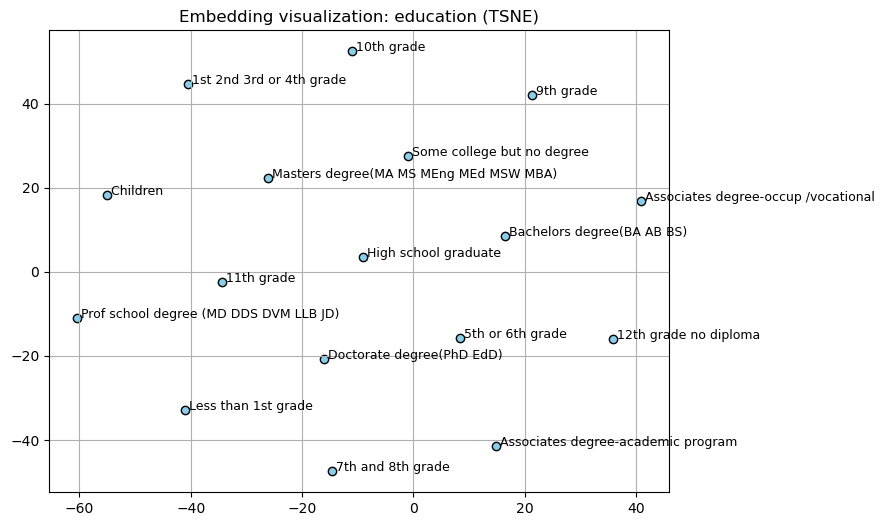

In [41]:
# Example visualization
visualize_embedding(model, 'education', cat_encoders['education'], method='tsne')


In [42]:

# ──────────────────────────────────────────────────────────────────────────────
# 7. Helper: get embedding for a specific row
# ──────────────────────────────────────────────────────────────────────────────

encoders_mapping = {col: {cls: idx for idx, cls in enumerate(enc.classes_)} for col, enc in cat_encoders.items()}

def get_row_embedding(row_series, model, enc_mapping, include_cont=True):
    vecs = []
    for col in cat_cols:
        idx = enc_mapping[col][row_series[col]]
        vecs.append(model.embeddings[col](torch.tensor([idx])).squeeze(0))
    if include_cont and cont_cols:
        cont_vec = torch.tensor(scaler.transform(row_series[cont_cols].values.reshape(1, -1)), dtype=torch.float32).squeeze(0)
        vecs.append(cont_vec)
    return torch.cat(vecs)

row0_emb = get_row_embedding(df.iloc[0], model, encoders_mapping)
print("Row 0 embedding shape:", row0_emb.shape)


Row 0 embedding shape: torch.Size([201])


/Users/degi/opt/anaconda3/envs/geospatial/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [43]:
row0_emb
row0_emb = get_row_embedding(df.iloc[0], model, encoders_mapping)

tensor([-0.3065,  0.5073,  0.0258, -0.2660,  1.4920,  0.9489, -1.1208,  0.5202,
        -0.7544, -0.6212, -1.5523,  0.2115, -1.1449,  0.5058, -0.7449,  0.2493,
        -0.7104, -1.3342, -0.0409, -1.7421,  0.6995,  0.0740,  0.8510, -0.7693,
         1.2801,  0.2998,  0.1719,  0.7488,  1.0004,  1.5368,  0.6793,  0.5576,
        -1.1611,  0.9321,  1.0581, -1.2993,  0.4414,  0.0229, -0.7094,  0.2624,
         0.8571, -0.9670,  0.9764, -0.0594, -0.7721,  1.0427,  1.4080,  0.9130,
         0.6236,  2.9863,  0.2339,  1.0990,  0.1339, -2.1765,  0.9016, -0.6806,
        -1.3836,  0.8553,  1.0392, -0.9717,  0.7469,  0.8643,  0.8878, -0.4441,
         1.2458, -0.6415, -1.1188, -0.4789,  1.8055, -1.8680, -0.2260, -0.2484,
        -1.8202,  0.5481, -1.1190, -0.8036,  1.0241,  1.0446, -0.6043, -0.9346,
         0.6154,  0.6608,  0.0902, -0.3111, -0.5225,  0.4601, -1.2039, -1.0455,
         0.3176, -0.6729,  1.9545, -0.5561,  1.1037, -1.0372,  0.1222,  1.0161,
        -1.8916, -0.8628, -0.3146,  0.04